## Load Data

In [1]:
#Import libraries & Yahoo Finance API
import datetime, time
import yfinance as yfin
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#import seaborn as sns
from datetime import date
import itertools
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

pd.options.display.float_format = "{:,.6f}".format #Set decimal places

In [7]:
# Starting and end dates
#start = datetime.date(2020, 6, 1)
#end = datetime.date(2025, 10, 18)

#!pip install curl_cffi -U
#from curl_cffi import requests
#session = requests.Session(impersonate = 'chrome')

# Get SA stock data
#df = yfin.download(["SSW.JO", "PPE.JO"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get US ETF & Treasury Yield data
#df_etf = yfin.download(["SPY", "^TYX", "EZA"], start, end, auto_adjust = False, session = session)["Adj Close"]

# Get Weekend data
#df_wkd = yfin.download(["USDZAR=X"], start, end, auto_adjust = False, session = session)["Adj Close"]
#df_wkd1 = yfin.download(["BTC-USD"], start, end, auto_adjust = False, session = session)["Adj Close"]

#df.to_csv("market_data.csv", index = False) #save to csv file, removing indexes
df = pd.read_csv("market_data.xls")

print(df)

             NPN.JO     PPE.JO        SBK.JO        SOL.JO       SSW.JO
0     56,992.765625  49.955502  9,619.172852 10,087.383789 3,340.525635
1     58,292.601562  49.955502 10,093.652344 11,735.321289 3,590.965332
2     58,690.550781  44.078300 11,346.636719 12,459.416016 3,372.453857
3     57,492.707031  44.078300 11,235.992188 12,828.954102 3,512.141602
4     58,456.582031  47.996399 11,934.752930 14,981.261719 3,431.322510
...             ...        ...           ...           ...          ...
1342 121,144.000000 240.000000 25,402.000000 10,122.000000 5,077.000000
1343 120,525.000000 230.000000 25,300.000000 10,341.000000 5,125.000000
1344 120,672.000000 228.000000 25,396.000000 10,331.000000 5,206.000000
1345 118,872.000000 220.000000 25,390.000000 10,345.000000 5,624.000000
1346 118,321.000000 215.000000 25,179.000000  9,503.000000 5,073.000000

[1347 rows x 5 columns]


# Relative Strength Indicator

In [9]:
##RSI Calculation
def calculate_rsi(prices, period=14):
    delta = prices.diff()#.dropna() # Calculate price changes
    
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)

    gain_series = pd.Series(gain, index=prices.index)
    loss_series = pd.Series(loss, index=prices.index)

    #Smoothed averages (reacts better to changing market momentum)
    avg_gain = gain_series.ewm(alpha=1/period, min_periods=period).mean()
    avg_loss = loss_series.ewm(alpha=1/period, min_periods=period).mean()

    rs = avg_gain / avg_loss # Relative Strength
    
    rsi = 100 - (100 / (1 + rs)) # RSI formula
    return rsi

In [43]:
##Trend Filter (MA50 vs MA200)
def trnd_fltr(dat, MA_lwr, MA_upp):
    dat['MA_lwr'] = dat['Price'].rolling(MA_lwr).mean() #Shorter window
    dat['MA_upp'] = dat['Price'].rolling(MA_upp).mean() #Longer window

    # Trend Identifier
    dat['Trend'] = np.where(dat['MA_lwr'] > dat['MA_upp'], 'Uptrend', 'Downtrend')

    return dat

In [11]:
#Assign values
def rez_id(bps_change):
    #Initiate
    bps_sucs = 0
    bps_gnd = 0
    bps_fail = 0
    bps_lst = 0

    #Conditions
    if bps_change > 0:
        bps_sucs = 1
        bps_gnd = bps_change
    else:
        bps_fail = 1
        bps_lst = abs(bps_change)

    return bps_sucs, bps_fail, bps_gnd, bps_lst

In [63]:
##Main RSI Performance Analysis Function
def metr_rsi_v2(data, start_date, end_date, lookahead=3, period=14, MA_lwr=50, MA_upp=200, rsi_bnch=(70, 30)):
    # Slice data
    data = data.loc[start_date:end_date].copy()
    
    # Calculate RSI
    rsi = calculate_rsi(data, period=period)
    
    # Create dataframe
    data = pd.DataFrame({
                "Price": data.loc[:],
                "RSI": rsi.loc[:]})
    
    # Generate Buy/Sell signals
    data['Signal'] = np.where(data['RSI'] > rsi_bnch[0], 'Sell',
                      np.where(data['RSI'] < rsi_bnch[1], 'Buy', 'None'))
    
    #Trend Filter
    data = trnd_fltr(data, MA_lwr, MA_upp)
    
    #Performance Testing
    results = []
    for i in range(len(data) - lookahead):
        #Initiate results variables
        bps_sucs = 0
        bps_gnd = 0
        bps_fail = 0
        bps_lst = 0
        
        current_price = data['Price'].iloc[i]
        future_price = data['Price'].iloc[i + lookahead]
        
        if data['Signal'].iloc[i] == 'Buy':
            #Calc Bps change (MY POSITION!)
            bps_chng = ((future_price - current_price) / current_price) * 10000
            #Assign variables
            bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)

        elif data['Signal'].iloc[i] == 'Sell':
            bps_chng = ((current_price - future_price) / current_price) * 10000

            bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)

        else:
            
            if data['Trend'].iloc[i] == 'Uptrend':
                bps_chng = ((future_price - current_price) / current_price) * 10000
                
                bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)

            else:
                bps_chng = ((current_price - future_price) / current_price) * 10000
                
                bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)
                   
        results.append({
            'Date': data.index[i],
            'Signal': data['Signal'].iloc[i],
            'bps_change': bps_chng,
            '#Trades_Gain': bps_sucs,
            '#Trades_Lost': bps_fail,
            'bps_gained': bps_gnd,
            'bps_lost': bps_lst,
            'Trend': data['Trend'].iloc[i]
            })
            
    results_df = pd.DataFrame(results)
    
    #print(results_df[results_df['Signal'] == 'Buy'].head())
    #Performance Summary
    summary = results_df.groupby(['Signal', 'Trend'])['bps_change'].agg(['count', 'mean', 'median', 'std'])
    win_rate = results_df.groupby(['Signal', 'Trend']).apply(
        lambda x: (x['bps_change'] > 0).mean() * 100).rename('Win_Rate(%)')
    
    summary = summary.join(win_rate)

    #Return both detailed and Summary results
    return summary, results_df, data

ChatGPT

In [ ]:
def metr_rsi_v2_enhanced(data, start_date, end_date, lookahead=3, period=14, 
                         MA_lwr=50, MA_upp=200, rsi_bnch=(70, 30), plot=True):
    """
    Enhanced RSI Performance Analysis Function
    ------------------------------------------
    Includes Sharpe ratio, expected value, win/loss metrics,
    and optional visualization.
    """

    # Ensure datetime index and proper slicing
    data = data.copy()
    data.index = pd.to_datetime(data.index)
    data = data.loc[start_date:end_date].sort_index()

    # Calculate RSI
    rsi = calculate_rsi(data, period=period)
    
    # Build working DataFrame
    data = pd.DataFrame({"Price": data, "RSI": rsi})

    # Identify crossovers
    data['RSI_prev'] = data['RSI'].shift(1)
    data['RSI_Cross'] = np.select([
        (data['RSI_prev'] < rsi_bnch[1]) & (data['RSI'] >= rsi_bnch[1]),
        (data['RSI_prev'] > rsi_bnch[0]) & (data['RSI'] <= rsi_bnch[0])
    ], ['Buy_Cross', 'Sell_Cross'], default='None')

    # Base signals (threshold logic)
    data['Signal'] = np.select(
        [data['RSI'] > rsi_bnch[0],
         data['RSI'] < rsi_bnch[1]],
        ['Sell', 'Buy'],
        default='Hold'
    )

    # Trend filter
    data = trnd_fltr(data, MA_lwr, MA_upp)

    # Performance testing
    results = []
    for i in range(len(data) - lookahead):
        current_price = data['Price'].iloc[i]
        future_price = data['Price'].iloc[i + lookahead]

        signal = data['Signal'].iloc[i]
        trend = data['Trend'].iloc[i]

        if signal == 'Buy':
            bps_chng = ((future_price - current_price) / current_price) * 10000
        elif signal == 'Sell':
            bps_chng = ((current_price - future_price) / current_price) * 10000
        else:
            # Follow the prevailing trend
            if trend == 'Uptrend':
                bps_chng = ((future_price - current_price) / current_price) * 10000
            else:
                bps_chng = ((current_price - future_price) / current_price) * 10000

        bps_sucs, bps_fail, bps_gnd, bps_lst = rez_id(bps_chng)

        results.append({
            'Date': data.index[i],
            'Signal': signal,
            'Trend': trend,
            'bps_change': bps_chng,
            '#Trades_Gain': bps_sucs,
            '#Trades_Lost': bps_fail,
            'bps_gained': bps_gnd,
            'bps_lost': bps_lst,
            'RSI': data['RSI'].iloc[i],
            'RSI_Cross': data['RSI_Cross'].iloc[i]
        })

    results_df = pd.DataFrame(results).set_index('Date')

    # ---- Performance Summary ----
    summary = results_df.groupby(['Signal', 'Trend'])['bps_change'].agg(['count', 'mean', 'median', 'std'])
    win_rate = results_df.groupby(['Signal', 'Trend']).apply(lambda x: (x['bps_change'] > 0).mean() * 100).rename('Win_Rate(%)')
    
    summary = summary.join(win_rate)
    summary['Sharpe'] = summary['mean'] / summary['std']
    
    # Compute win/loss ratio and expected value
    gain_stats = results_df[results_df['bps_change'] > 0]['bps_change'].mean()
    loss_stats = abs(results_df[results_df['bps_change'] < 0]['bps_change'].mean())
    overall_wr = (results_df['bps_change'] > 0).mean() * 100

    summary['Win/Loss_Ratio'] = gain_stats / loss_stats if loss_stats != 0 else np.nan
    summary['Expected_Value'] = (overall_wr/100 * gain_stats) - ((1 - overall_wr/100) * loss_stats)

    # ---- Visualization ----
    if plot:
        fig, axes = plt.subplots(2, 1, figsize=(12, 7), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # Price Plot
        axes[0].plot(data.index, data['Price'], label='Price', color='black')
        axes[0].plot(data['MA_lwr'], label=f'MA{MA_lwr}', linestyle='--', alpha=0.6)
        axes[0].plot(data['MA_upp'], label=f'MA{MA_upp}', linestyle='--', alpha=0.6)

        buy_points = results_df[results_df['Signal'] == 'Buy'].index
        sell_points = results_df[results_df['Signal'] == 'Sell'].index

        axes[0].scatter(buy_points, data.loc[buy_points, 'Price'], color='green', marker='^', label='Buy Signal')
        axes[0].scatter(sell_points, data.loc[sell_points, 'Price'], color='red', marker='v', label='Sell Signal')
        axes[0].set_title('Price and Signals')
        axes[0].legend()

        # RSI Plot
        axes[1].plot(data.index, data['RSI'], label='RSI', color='blue')
        axes[1].axhline(rsi_bnch[0], color='red', linestyle='--', label=f'Overbought {rsi_bnch[0]}')
        axes[1].axhline(rsi_bnch[1], color='green', linestyle='--', label=f'Oversold {rsi_bnch[1]}')
        axes[1].set_title('RSI Levels')
        axes[1].legend()

        plt.tight_layout()
        plt.show()

    return summary, results_df, data

Copilot

In [ ]:
import numpy as np
import pandas as pd

def compute_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_dd = drawdown.min()
    return drawdown, max_dd

def sharpe_ratio(returns, periods_per_year=252):
    # Annualized Sharpe using daily-like returns; adjust periods_per_year for your data frequency
    mu = returns.mean() * periods_per_year
    sigma = returns.std(ddof=1) * np.sqrt(periods_per_year)
    return mu / sigma if sigma != 0 else np.nan

def sortino_ratio(returns, periods_per_year=252):
    downside = returns[returns < 0]
    dd_sigma = downside.std(ddof=1) * np.sqrt(periods_per_year)
    mu = returns.mean() * periods_per_year
    return mu / dd_sigma if dd_sigma != 0 else np.nan

def performance_summary(returns, label=None, periods_per_year=252):
    # returns should be in decimal (e.g., 0.001 for 10 bps), not bps
    cum_ret = (1 + returns).cumprod()
    _, max_dd = compute_drawdown(cum_ret)
    out = {
        'Count': returns.count(),
        'Mean': returns.mean(),
        'Median': returns.median(),
        'Std': returns.std(ddof=1),
        'Sharpe': sharpe_ratio(returns, periods_per_year),
        'Sortino': sortino_ratio(returns, periods_per_year),
        'Max_Drawdown': max_dd,
        'Total_Return': cum_ret.iloc[-1] - 1 if len(cum_ret) else np.nan
    }
    return pd.Series(out, name=label if label else 'Summary')

def add_atr(df, period=14):
    # df requires columns: 'High','Low','Close'
    tr1 = df['High'] - df['Low']
    tr2 = (df['High'] - df['Close'].shift(1)).abs()
    tr3 = (df['Low'] - df['Close'].shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df['ATR'] = tr.ewm(alpha=1/period, min_periods=period).mean()
    return df

def add_bollinger_width(df, price_col='Price', period=20, num_std=2):
    ma = df[price_col].rolling(period).mean()
    std = df[price_col].rolling(period).std(ddof=1)
    upper = ma + num_std * std
    lower = ma - num_std * std
    df['BB_Width'] = (upper - lower) / ma
    return df

def label_vol_regime(df, method='ATR', threshold='median'):
    # method: 'ATR' or 'BB_Width'
    col = 'ATR' if method == 'ATR' else 'BB_Width'
    if threshold == 'median':
        th = df[col].median()
    elif isinstance(threshold, (int, float)):
        th = threshold
    else:
        raise ValueError("threshold must be 'median' or numeric")
    df['Vol_Regime'] = np.where(df[col] <= th, 'LowVol', 'HighVol')
    return df

def apply_costs(returns, cost_bps=5, slippage_bps=0):
    # returns in decimal; costs/slippage in bps
    total_bps = cost_bps + slippage_bps
    net_returns = returns - (total_bps / 10000.0)
    return net_returns

def rsi_signals(df, rsi_col='RSI', upper=70, lower=30, mode='threshold'):
    # mode: 'threshold' uses upper/lower levels; 'cross' uses crossing events
    sig = pd.Series('None', index=df.index)
    if mode == 'threshold':
        sig = np.where(df[rsi_col] > upper, 'Sell', np.where(df[rsi_col] < lower, 'Buy', 'None'))
    elif mode == 'cross':
        buy_cross = (df[rsi_col].shift(1) >= lower) & (df[rsi_col] < lower)
        sell_cross = (df[rsi_col].shift(1) <= upper) & (df[rsi_col] > upper)
        sig = np.where(buy_cross, 'Buy', np.where(sell_cross, 'Sell', 'None'))
    return pd.Series(sig, index=df.index, name='Signal')

def trend_filter(df, price_col='Price', ma_short=50, ma_long=200):
    df['MA_Short'] = df[price_col].rolling(ma_short).mean()
    df['MA_Long'] = df[price_col].rolling(ma_long).mean()
    df['Trend'] = np.where(df['MA_Short'] > df['MA_Long'], 'Uptrend', 'Downtrend')
    return df

def forward_return(df, price_col='Price', horizon=3):
    # Decimal forward return
    return (df[price_col].shift(-horizon) - df[price_col]) / df[price_col]

def trailing_stop_exit(prices, entry_idx, direction, stop_bps=100):
    # direction: 'long' or 'short'
    # stop_bps = trailing stop distance (e.g., 100 bps = 1%)
    stop_pct = stop_bps / 10000.0
    best = prices.iloc[entry_idx]
    for i in range(entry_idx + 1, len(prices)):
        px = prices.iloc[i]
        if direction == 'long':
            best = max(best, px)
            if px <= best * (1 - stop_pct):
                return i
        else:  # short
            best = min(best, px)
            if px >= best * (1 + stop_pct):
                return i
    return None  # no stop hit

def neutral_exit_idx(rsi_series, entry_idx, lower=30, upper=70, direction='long'):
    # Exit when RSI returns to neutral band [lower, upper]
    for i in range(entry_idx + 1, len(rsi_series)):
        r = rsi_series.iloc[i]
        if lower <= r <= upper:
            return i
    return None

def compute_trade_returns(df, price_col='Price', rsi_col='RSI',
                          upper=70, lower=30, ma_short=50, ma_long=200,
                          vol_method='ATR', vol_threshold='median',
                          horizon=3, exit_mode='time',  # 'time'|'neutral'|'trailing'
                          trailing_bps=100, cost_bps=5, slippage_bps=0,
                          only_with_trend=True, vol_regime_filter=None):
    """
    Build trade list and per-trade returns using variable exits and costs.
    """
    df = df.copy()
    df = trend_filter(df, price_col=price_col, ma_short=ma_short, ma_long=ma_long)
    df = add_atr(df) if vol_method == 'ATR' else add_bollinger_width(df, price_col=price_col)
    df = label_vol_regime(df, method=vol_method, threshold=vol_threshold)
    df['Signal'] = rsi_signals(df, rsi_col=rsi_col, upper=upper, lower=lower, mode='threshold')

    trades = []
    prices = df[price_col]
    rsi = df[rsi_col]

    for i in range(len(df) - 1):
        sig = df['Signal'].iloc[i]
        if sig == 'None':
            continue

        # Trend filter application
        trnd = df['Trend'].iloc[i]
        if only_with_trend:
            if sig == 'Buy' and trnd != 'Uptrend':
                continue
            if sig == 'Sell' and trnd != 'Downtrend':
                continue

        # Vol regime filter
        vol_reg = df['Vol_Regime'].iloc[i]
        if vol_regime_filter and vol_reg != vol_regime_filter:
            continue

        entry_px = prices.iloc[i]
        direction = 'long' if sig == 'Buy' else 'short'

        # Determine exit index
        exit_idx = None
        if exit_mode == 'time':
            exit_idx = i + horizon if (i + horizon) < len(df) else None
        elif exit_mode == 'neutral':
            exit_idx = neutral_exit_idx(rsi, i, lower=lower, upper=upper, direction=direction)
        elif exit_mode == 'trailing':
            exit_idx = trailing_stop_exit(prices, i, direction=direction, stop_bps=trailing_bps)
        else:
            raise ValueError("exit_mode must be 'time', 'neutral', or 'trailing'")

        if exit_idx is None:
            continue  # skip incomplete trades

        exit_px = prices.iloc[exit_idx]

        # Raw return in decimal
        if direction == 'long':
            ret = (exit_px - entry_px) / entry_px
        else:
            ret = (entry_px - exit_px) / entry_px

        # Apply costs and slippage
        net_ret = apply_costs(pd.Series([ret]), cost_bps=cost_bps, slippage_bps=slippage_bps).iloc[0]

        trades.append({
            'EntryDate': df.index[i],
            'ExitDate': df.index[exit_idx],
            'Signal': sig,
            'Trend': trnd,
            'Vol_Regime': vol_reg,
            'EntryPrice': entry_px,
            'ExitPrice': exit_px,
            'RawReturn': ret,
            'NetReturn': net_ret,
            'HoldingPeriod': exit_idx - i,
        })

    trades_df = pd.DataFrame(trades)
    return trades_df

def analyze_rsi_methodology(price_series, rsi_series,
                            upper=70, lower=30, ma_short=50, ma_long=200,
                            vol_method='ATR', vol_threshold='median',
                            horizon=3, exit_mode='time', trailing_bps=100,
                            cost_bps=5, slippage_bps=0,
                            only_with_trend=True, vol_regime_filter=None,
                            periods_per_year=252):
    """
    price_series: pd.Series of prices
    rsi_series: pd.Series of RSI values aligned with price_series index
    Returns summary tables and per-trade dataframe.
    """
    df = pd.DataFrame({'Price': price_series, 'RSI': rsi_series}).dropna()

    trades_df = compute_trade_returns(
        df, price_col='Price', rsi_col='RSI',
        upper=upper, lower=lower, ma_short=ma_short, ma_long=ma_long,
        vol_method=vol_method, vol_threshold=vol_threshold,
        horizon=horizon, exit_mode=exit_mode, trailing_bps=trailing_bps,
        cost_bps=cost_bps, slippage_bps=slippage_bps,
        only_with_trend=only_with_trend, vol_regime_filter=vol_regime_filter
    )

    if trades_df.empty:
        return (
            pd.DataFrame(), pd.DataFrame(), trades_df
        )

    # Global summary on NetReturn
    global_summary = performance_summary(trades_df['NetReturn'], label='Overall', periods_per_year=periods_per_year)

    # Breakdown summaries
    by_signal = trades_df.groupby('Signal')['NetReturn'].apply(
        lambda r: performance_summary(r, periods_per_year=periods_per_year)
    ).unstack()

    by_trend = trades_df.groupby(['Signal', 'Trend'])['NetReturn'].apply(
        lambda r: performance_summary(r, periods_per_year=periods_per_year)
    ).unstack()

    by_vol = trades_df.groupby(['Signal', 'Vol_Regime'])['NetReturn'].apply(
        lambda r: performance_summary(r, periods_per_year=periods_per_year)
    ).unstack()

    # Holding period distribution
    hp_dist = trades_df.groupby('Signal')['HoldingPeriod'].describe()

    return global_summary.to_frame().T, by_signal, by_trend, by_vol, hp_dist, trades_df

# Assuming you already have your price series and RSI computed:
# price_series = df_asset['Close']
# rsi_series = calculate_rsi(price_series, period=14)

global_summary, by_signal, by_trend, by_vol, hp_dist, trades_df = analyze_rsi_methodology(
    price_series=price_series,
    rsi_series=rsi_series,
    upper=70, lower=30,
    ma_short=50, ma_long=200,
    vol_method='ATR', vol_threshold='median',
    horizon=5, exit_mode='neutral',    # try 'time' or 'trailing'
    trailing_bps=100,
    cost_bps=8, slippage_bps=2,        # realistic costs matter
    only_with_trend=True,
    vol_regime_filter=None,            # or 'LowVol'/'HighVol' to filter
    periods_per_year=252               # adjust if weekly/monthly data
)

print(global_summary)
print(by_signal)
print(by_trend)
print(by_vol)
print(hp_dist)
print(trades_df.head())


In [82]:
#Function inputs:
    #Data - stock (adjusted) closing price
    #Start Date - The first date of analysis
    #End Date - The last date of analysis
    #NB: Analysis options include either duration measure (i.e. 1-,3-,6-month periods) or independently adjust start & end dates
    #Period - The duration of RSI measurement
    #Lookahead - Holding period, i.e. how many days you hold a stock before a 'new' position is taken
    #MA_lwr - Lower MA window in trend filter
    #MA_upp - Upper MA window in trend filter
    #rsi_upp - Upper bound for RSI 
    #rsi_lwr - Lower bound for RSI 

#Function outputs:
    #Summary - Computes metrics of bps change grouped by Signal & Trend
    #Results - Dataframe with results for each trading day position
    #Data - Output of RSI and Trend Filter trading strategy from price data

#An example:
print(df.index[-1] - pd.DateOffset(years=5, months=4, days=16))
print(df.index[-1])

f_summ, f_rez, f_dat = metr_rsi_v2(data=df_wkd["BTC-USD"] , start_date=df.index[-1] - pd.DateOffset(years=5, months=4, days=16), 
                                  end_date=df.index[-1], lookahead=3, MA_lwr=50, MA_upp=200, period=14, rsi_bnch=(70,30))

#Display results
print(f_summ)

print(f_rez)

print(f_dat)

2020-06-01 00:00:00
2025-10-17 00:00:00
                  count        mean      median        std  Win_Rate(%)
Signal Trend                                                           
Buy    Downtrend     25  152.088858  220.703122 636.338449    76.000000
       Uptrend       30  293.910559  118.395652 628.088592    73.333333
None   Downtrend    725  -38.684021  -37.166719 515.087280    45.517241
       Uptrend      943   12.958330    0.979135 503.363779    50.159067
Sell   Downtrend     98 -204.098536 -112.754501 508.973995    37.755102
       Uptrend      141 -185.463870  -98.491075 601.443669    41.134752
           Date Signal  bps_change  #Trades_Gain  #Trades_Lost  bps_gained  \
0    2020-06-01   None  360.600130             1             0  360.600130   
1    2020-06-02   None -142.426325             0             1    0.000000   
2    2020-06-03   None    3.146085             1             0    3.146085   
3    2020-06-04   None   42.634148             1             0   42.6341

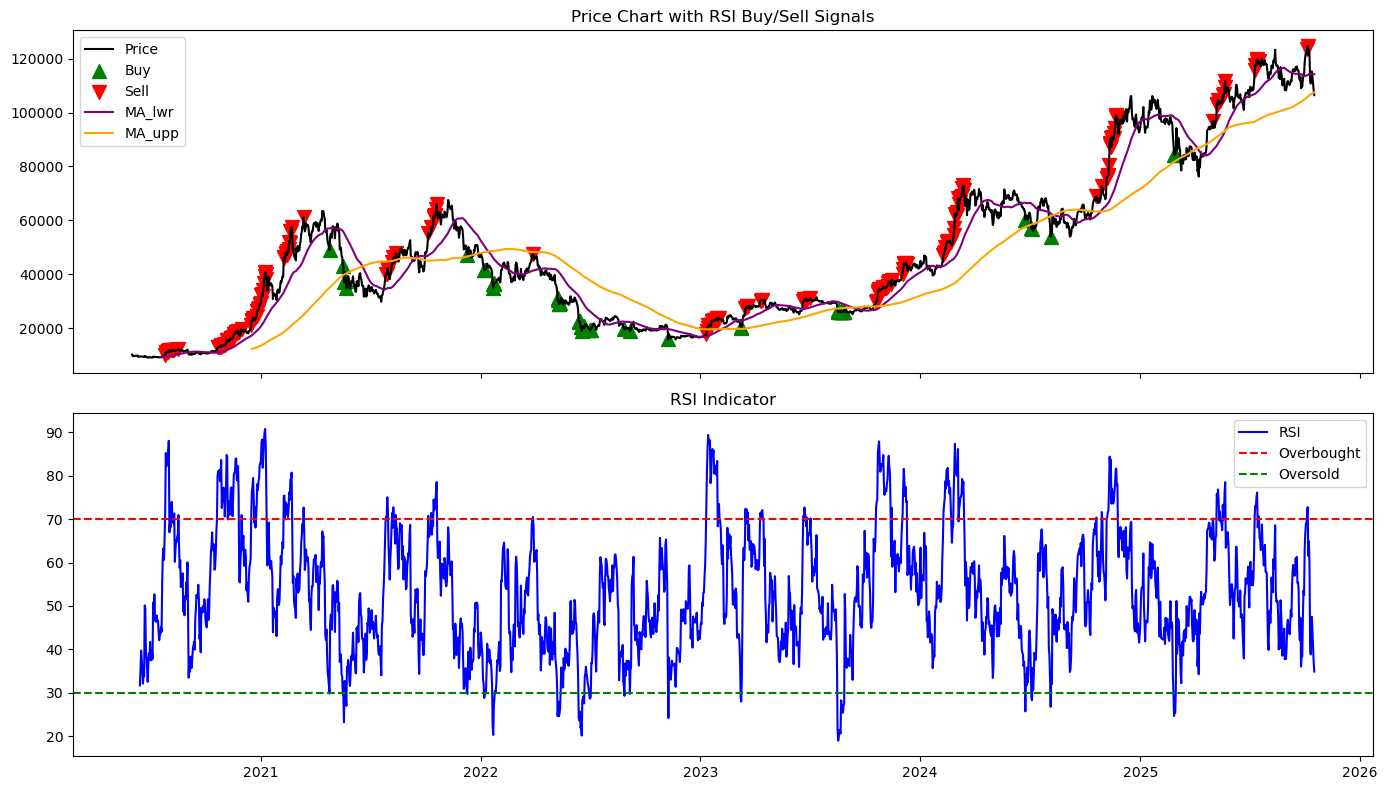

In [83]:
#Visualization
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

#Price with Buy/Sell markers
ax[0].plot(f_dat.index, f_dat['Price'], color='black', label='Price')
ax[0].scatter(f_dat.index[f_dat['Signal'] == 'Buy'], f_dat['Price'][f_dat['Signal'] == 'Buy'],
                  label='Buy', color='green', marker='^', s=100)
ax[0].scatter(f_dat.index[f_dat['Signal'] == 'Sell'], f_dat['Price'][f_dat['Signal'] == 'Sell'],
                  label='Sell', color='red', marker='v', s=100)
ax[0].plot(f_dat.index, f_dat['MA_lwr'], color='purple', label='MA_lwr')
ax[0].plot(f_dat.index, f_dat['MA_upp'], color='orange', label='MA_upp')
ax[0].set_title('Price Chart with RSI Buy/Sell Signals')
ax[0].legend()

#RSI subplot 
ax[1].plot(f_dat.index, f_dat['RSI'], color='blue', label='RSI')
ax[1].axhline(70, color='red', linestyle='--', label='Overbought')
ax[1].axhline(30, color='green', linestyle='--', label='Oversold')
ax[1].set_title('RSI Indicator')
ax[1].legend()
plt.tight_layout()
plt.show()

In [86]:
#Gridsearch

#Initiate input ranges:
dats = [df["SSW.JO"], df["PPE.JO"], df_etf["^TYX"], df_etf["EZA"], df_wkd["USDZAR=X"] , df_wkd1["BTC-USD"]]

starts = [
    df.index[-1] - pd.DateOffset(years=0, months=6),
    df.index[-1] - pd.DateOffset(years=1, months=0),
    df.index[-1] - pd.DateOffset(years=1, months=6),
    df.index[-1] - pd.DateOffset(years=2, months=0),
]

ends = [
    df.index[-1],
    df.index[-1] - pd.DateOffset(years=0, months=1),
    df.index[-1] - pd.DateOffset(years=0, months=3),
    df.index[-1] - pd.DateOffset(years=0, months=5),
]

lookaheads = [1, 4, 7, 10, 14, 20]

MA_lwrs = [5, 10, 20, 21, 30]

MA_upps = [20, 30, 50, 100]

periods = [7, 10, 14, 20, 27]

rsi_bnchs = [(70,30), (80,20), (60,40)]

# Grid search
best_params = None
best_score = float('-inf')
less_params = None
less_score = float('inf')

for dat, start, end, lookahead, MA_lwr, MA_upp, period, rsi_bnch in itertools.product(dats, starts, ends, lookaheads, MA_lwrs, MA_upps, 
                                                                                      periods, rsi_bnchs):
    if end <= start:
        continue  # Skip invalid date ranges
    if MA_upp <= MA_lwr:
        continue  # Skip invalid trend filters too!
    if (end.date() - start.date()).days <= MA_upp:
        continue  # There's no trend filter
    if lookahead >= MA_upp:
        continue  # There's no trend filter
    try:
        f_summ, f_rez,f_dat  = metr_rsi_v2(data=dat, start_date=start, end_date=end, lookahead=lookahead, MA_lwr=MA_lwr, 
            MA_upp=MA_upp, period=period, rsi_bnch=rsi_bnch)

        #Filter for RSI predictions
        #buy_sell_summary = f_summ.loc[f_summ.index.get_level_values('Signal').isin(['Buy', 'Sell'])]

        score = f_summ['mean'].mean()

    except Exception as e:
        print(f"Error for {dat.name}, {start}, {end}, {lookahead}, {MA_lwr}, {MA_upp}, {period}, {rsi_bnch}: {e}")
        continue

    if score > best_score:
        best_score = score
        best_params = (dat.name, start, end, lookahead, MA_lwr, MA_upp, period, rsi_bnch)

    if score < less_score:
        less_score = score
        less_params = (dat.name, start, end, lookahead, MA_lwr, MA_upp, period, rsi_bnch)

# Output best result
if best_params:
    print("Best combination found:")
    print(f"Data: {best_params[0]}")
    print(f"Start Date: {best_params[1].date()}; End Date: {best_params[2].date()}; Lookahead: {best_params[3]}")
    print(f"Lower MA: {best_params[4]}; Upper MA: {best_params[5]}; Period: {best_params[6]}; RSI Benchmarks: {best_params[7]}")
    print(f"Avg BPS Gained: {best_score:.2f}")
else:
    print("No valid combination found.")

# Output worst result
if less_params:
    print("Worst combination found:")
    print(f"Data: {less_params[0]}")
    print(f"Start Date: {less_params[1].date()}; End Date: {less_params[2].date()}; Lookahead: {less_params[3]}")
    print(f"Lower MA: {less_params[4]}; Upper MA: {less_params[5]}; Period: {less_params[6]}; RSI Benchmarks: {less_params[7]}")
    print(f"Avg BPS Lost: {less_score:.2f}")
else:
    print("No valid combination found.")

Best combination found:
Data: SSW.JO
Start Date: 2024-10-17; End Date: 2025-05-17; Lookahead: 20
Lower MA: 30; Upper MA: 50; Period: 14; RSI Benchmarks: (70, 30)
Avg BPS Gained: 1949.87
Worst combination found:
Data: SSW.JO
Start Date: 2025-04-17; End Date: 2025-07-17; Lookahead: 20
Lower MA: 5; Upper MA: 50; Period: 20; RSI Benchmarks: (60, 40)
Avg BPS Lost: -2495.56


1949.8650723276928
                  count         mean       median          std  Win_Rate(%)
Signal Trend                                                               
Buy    Downtrend      1   987.983979   987.983979          NaN   100.000000
       Uptrend        1 4,794.034091 4,794.034091          NaN   100.000000
None   Downtrend     91   324.900739   400.822199 1,037.522799    60.439560
       Uptrend       30 1,692.541481 1,676.591322 1,321.616329    86.666667


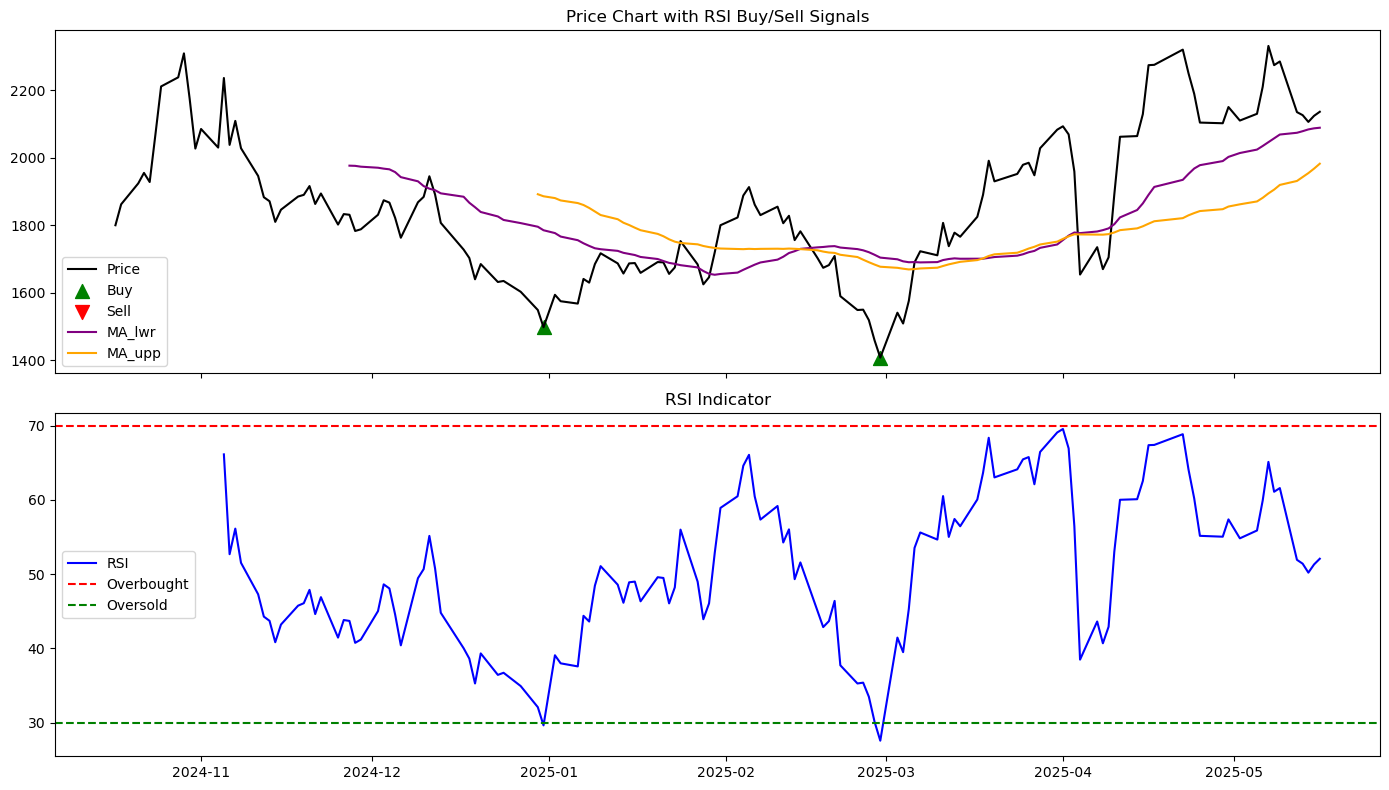

In [87]:
##Best combination
f_summ, f_rez,f_dat  = metr_rsi_v2(data=df["SSW.JO"], start_date=best_params[1], end_date=best_params[2], lookahead=best_params[3],
                                   MA_lwr=best_params[4], MA_upp=best_params[5], period=best_params[6], rsi_bnch=best_params[7])

print(f_summ['mean'].mean())
print(f_summ)

#Visualization
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

#Price with Buy/Sell markers
ax[0].plot(f_dat.index, f_dat['Price'], color='black', label='Price')
ax[0].scatter(f_dat.index[f_dat['Signal'] == 'Buy'], f_dat['Price'][f_dat['Signal'] == 'Buy'],
                  label='Buy', color='green', marker='^', s=100)
ax[0].scatter(f_dat.index[f_dat['Signal'] == 'Sell'], f_dat['Price'][f_dat['Signal'] == 'Sell'],
                  label='Sell', color='red', marker='v', s=100)
ax[0].plot(f_dat.index, f_dat['MA_lwr'], color='purple', label='MA_lwr')
ax[0].plot(f_dat.index, f_dat['MA_upp'], color='orange', label='MA_upp')
ax[0].set_title('Price Chart with RSI Buy/Sell Signals')
ax[0].legend()

#RSI subplot 
ax[1].plot(f_dat.index, f_dat['RSI'], color='blue', label='RSI')
ax[1].axhline(best_params[7][0], color='red', linestyle='--', label='Overbought')
ax[1].axhline(best_params[7][1], color='green', linestyle='--', label='Oversold')
ax[1].set_title('RSI Indicator')
ax[1].legend()
plt.tight_layout()
plt.show()

                  count          mean        median          std  Win_Rate(%)
Signal Trend                                                                 
None   Downtrend     19 -3,098.242436 -3,012.313105 1,055.466412     0.000000
Sell   Downtrend     22 -1,892.874401 -1,797.988722   535.586026     0.000000


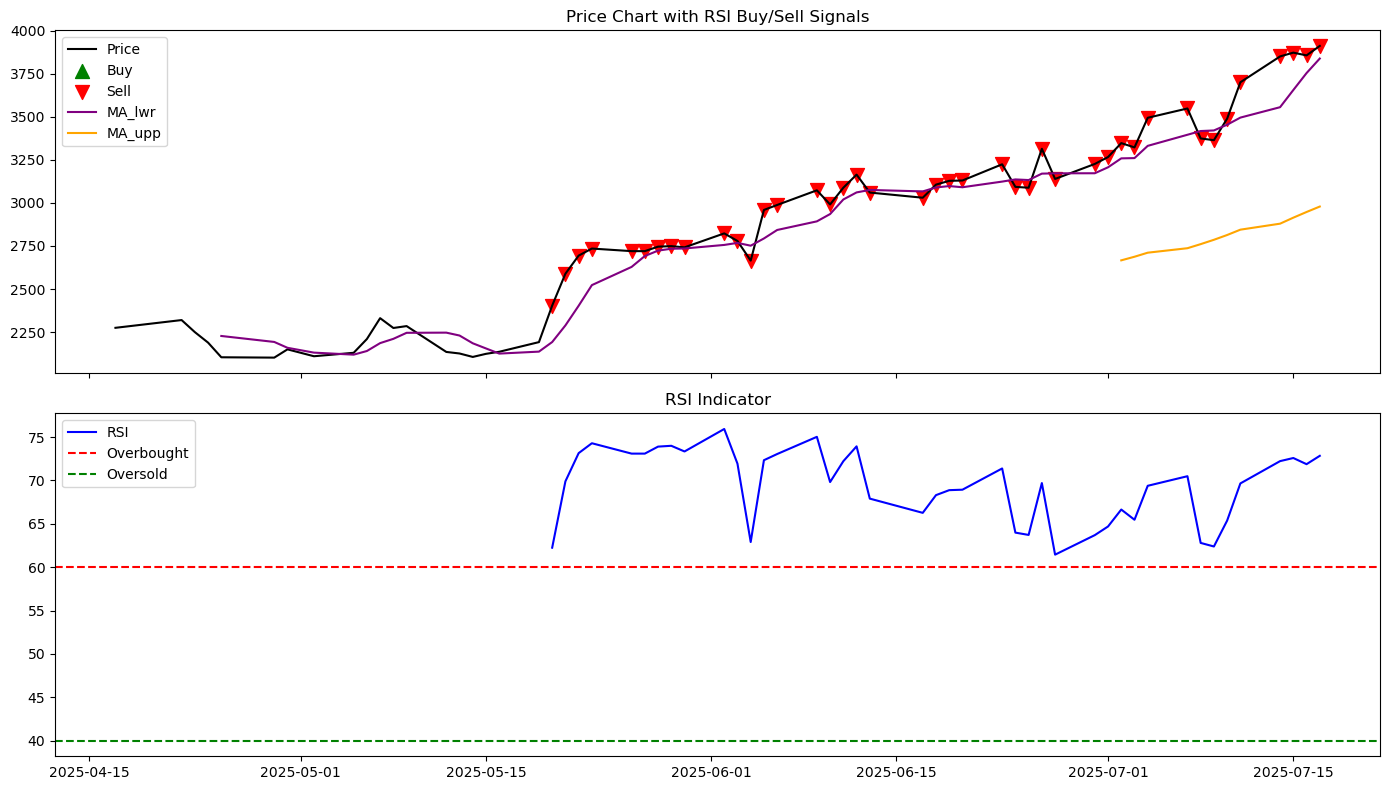

In [88]:
##Worst combination
f_summ, f_rez,f_dat = metr_rsi_v2(data=df["SSW.JO"], start_date=less_params[1], end_date=less_params[2], lookahead=less_params[3],
                                   MA_lwr=less_params[4], MA_upp=less_params[5], period=less_params[6], rsi_bnch=less_params[7])

print(f_summ)

#Visualization
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

#Price with Buy/Sell markers
ax[0].plot(f_dat.index, f_dat['Price'], color='black', label='Price')
ax[0].scatter(f_dat.index[f_dat['Signal'] == 'Buy'], f_dat['Price'][f_dat['Signal'] == 'Buy'],
                  label='Buy', color='green', marker='^', s=100)
ax[0].scatter(f_dat.index[f_dat['Signal'] == 'Sell'], f_dat['Price'][f_dat['Signal'] == 'Sell'],
                  label='Sell', color='red', marker='v', s=100)
ax[0].plot(f_dat.index, f_dat['MA_lwr'], color='purple', label='MA_lwr')
ax[0].plot(f_dat.index, f_dat['MA_upp'], color='orange', label='MA_upp')
ax[0].set_title('Price Chart with RSI Buy/Sell Signals')
ax[0].legend()

#RSI subplot 
ax[1].plot(f_dat.index, f_dat['RSI'], color='blue', label='RSI')
ax[1].axhline(less_params[7][0], color='red', linestyle='--', label='Overbought')
ax[1].axhline(less_params[7][1], color='green', linestyle='--', label='Oversold')
ax[1].set_title('RSI Indicator')
ax[1].legend()
plt.tight_layout()
plt.show()

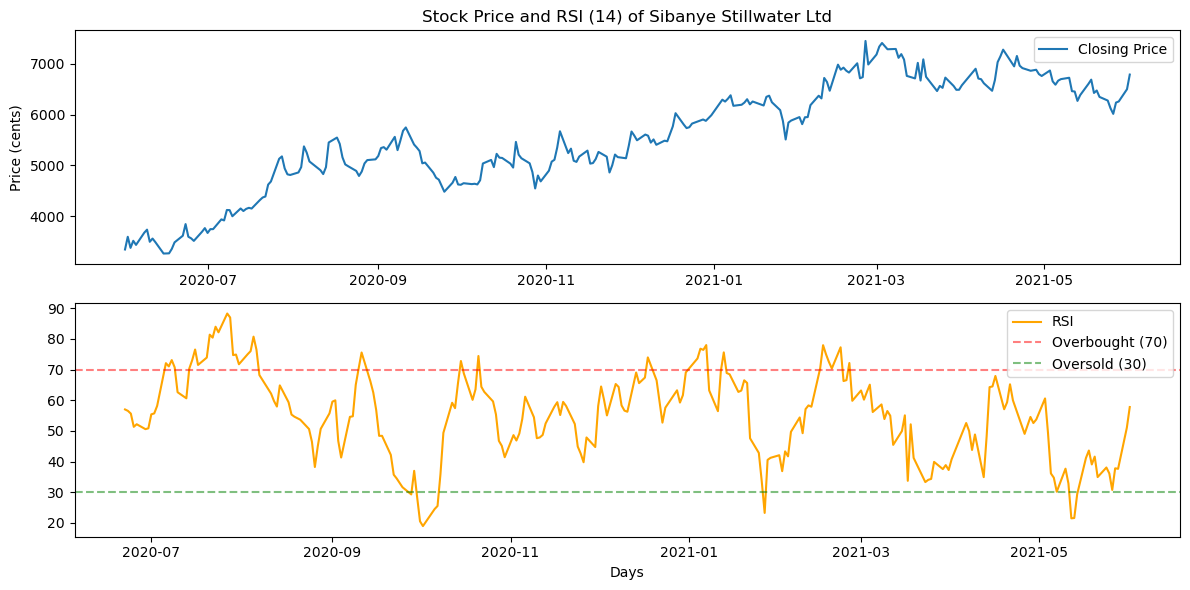

In [82]:
#Technical Does Not Works!

plt.figure(figsize=(12, 6))
# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2020-06-01":"2021-06-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and RSI (14) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(dat.loc["2020-06-01":"2021-06-01"], label='RSI', color='orange')
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label='Oversold (30)')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

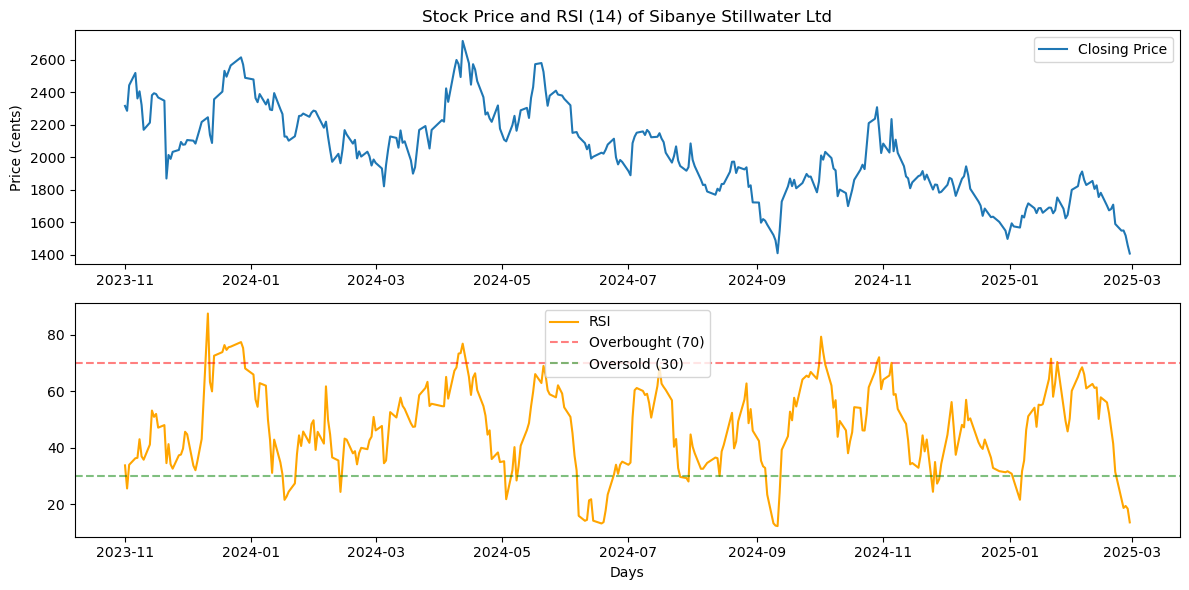

In [83]:
#Technical Works!

plt.figure(figsize=(12, 6))
# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2023-11-01":"2025-03-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and RSI (14) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(dat.loc["2023-11-01":"2025-03-01"], label='RSI', color='orange')
plt.axhline(70, linestyle='--', color='red', alpha=0.5, label='Overbought (70)')
plt.axhline(30, linestyle='--', color='green', alpha=0.5, label='Oversold (30)')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

# Bollinger Bands

In [84]:
# Define parameters
window_size = 20
num_std = 2

rolling_dat = df.index[window_size-1:]

# Calculate rolling mean and standard deviation
rolling_mean = np.convolve(df["SSW.JO"], np.ones(window_size)/window_size, mode='valid')
rolling_std = np.std([df["SSW.JO"][i:i+window_size] for i in range(len(df["SSW.JO"])-window_size+1)], axis=1)

# Calculate Bollinger Bands
upper_band = rolling_mean + num_std * rolling_std
lower_band = rolling_mean - num_std * rolling_std

rolling_df = pd.DataFrame({
                "Date": rolling_dat,
                "Mean": rolling_mean,
                "Std": rolling_std,
                "Upper": upper_band,
                "Lower": lower_band})

#Set index
rolling_df = rolling_df.set_index("Date")

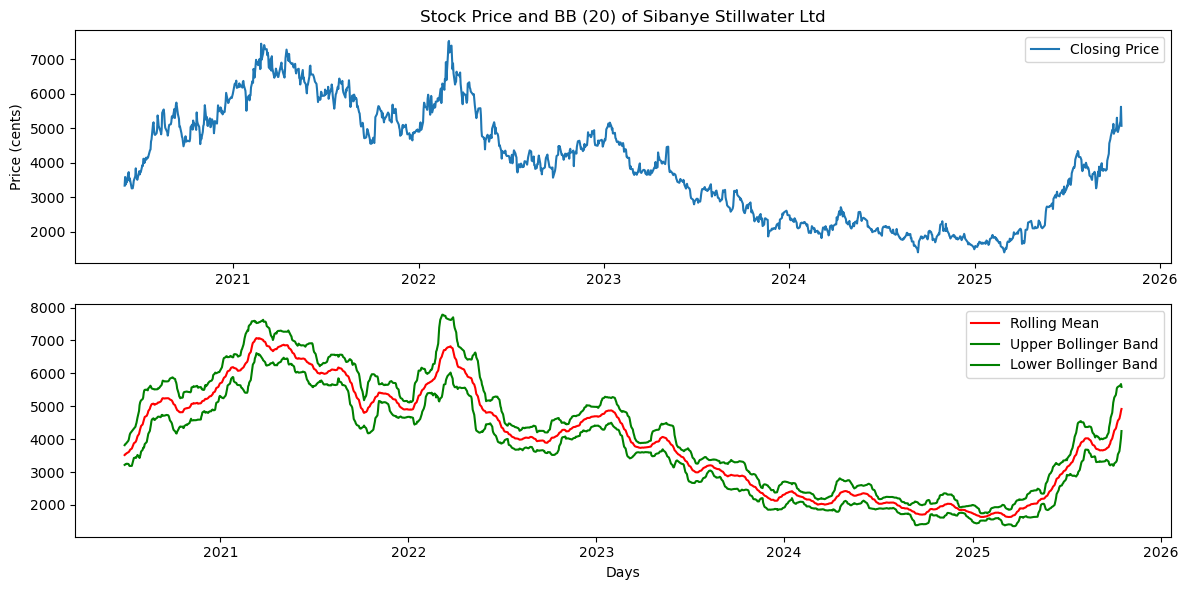

In [85]:
# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df["SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df["Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df["Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df["Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

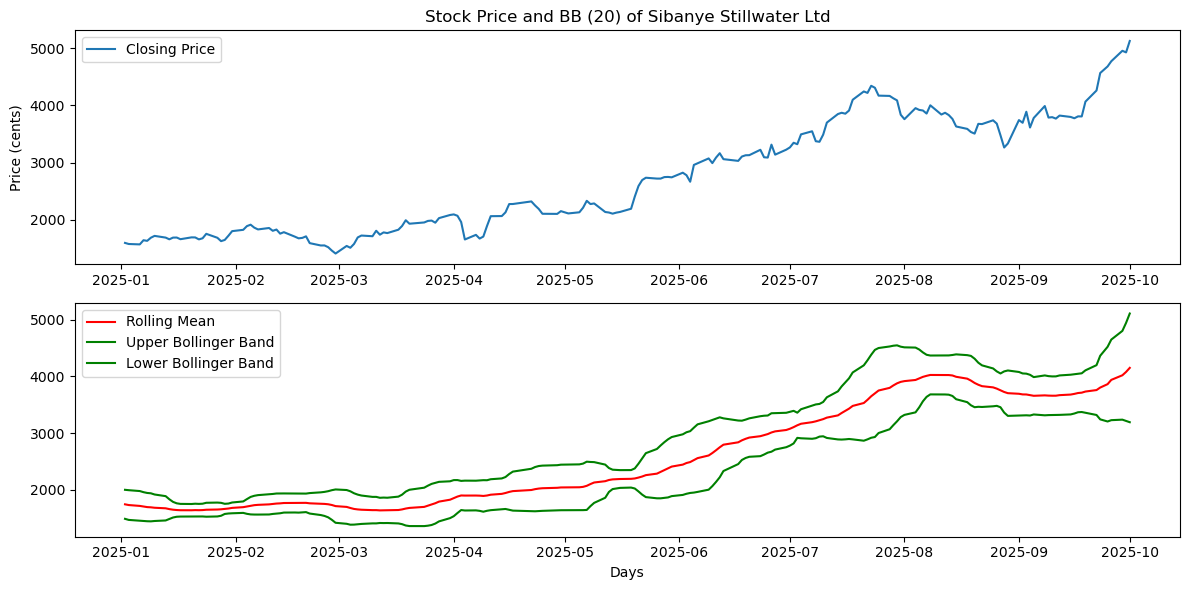

In [86]:
#Technical Works!

# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2025-01-01":"2025-10-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df.loc["2025-01-01":"2025-10-01", "Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

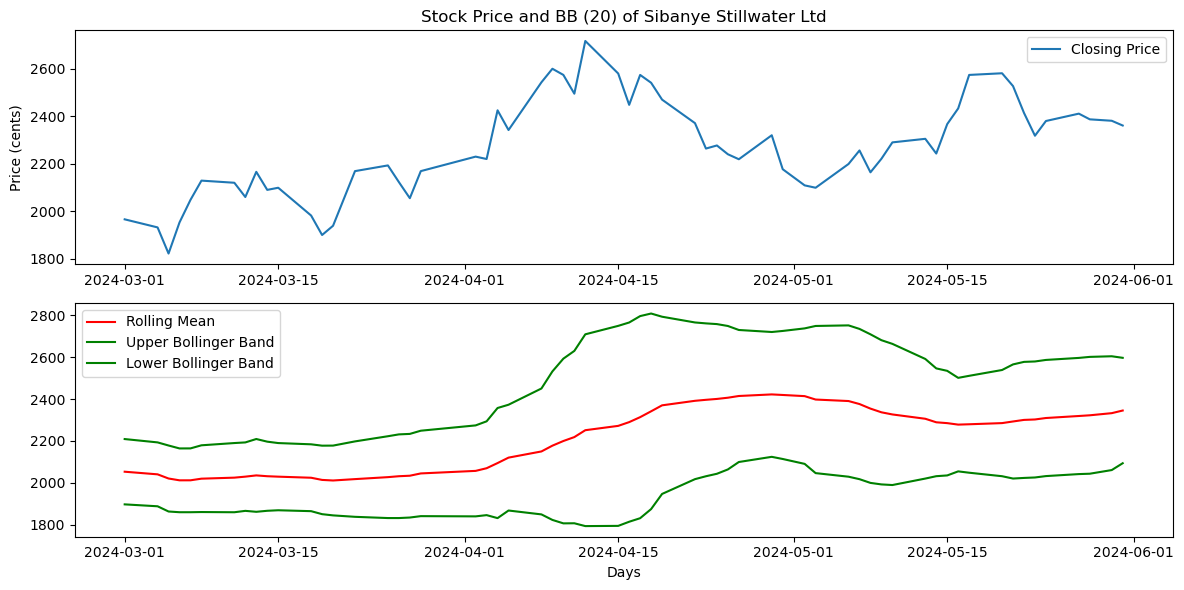

In [87]:
#Technical Does Not Works!

# Plotting
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df.loc["2024-03-01":"2024-06-01", "SSW.JO"], label='Closing Price')
plt.title('Stock Price and BB (20) of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Mean"], label='Rolling Mean', color='red')
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Upper"], label='Upper Bollinger Band', color='green')
plt.plot(rolling_df.loc["2024-03-01":"2024-06-01", "Lower"], label='Lower Bollinger Band', color='green')
plt.legend()
plt.xlabel('Days')
plt.tight_layout()
plt.show()

# Moving Average Convergence/Divergence Oscillator (MACD)

In [88]:
# Function to calculate MACD and Signal Line
def calculate_macd(prices, short_window=12, long_window=26, signal_window=9):
   short_ema = prices.ewm(span=short_window, adjust=False).mean() # Short-term EMA
   long_ema = prices.ewm(span=long_window, adjust=False).mean() # Long-term EMA
    
   macd_line = short_ema - long_ema # MACD Line
    
   signal_line = macd_line.ewm(span=signal_window, adjust=False).mean() # Signal Line
    
   return macd_line, signal_line

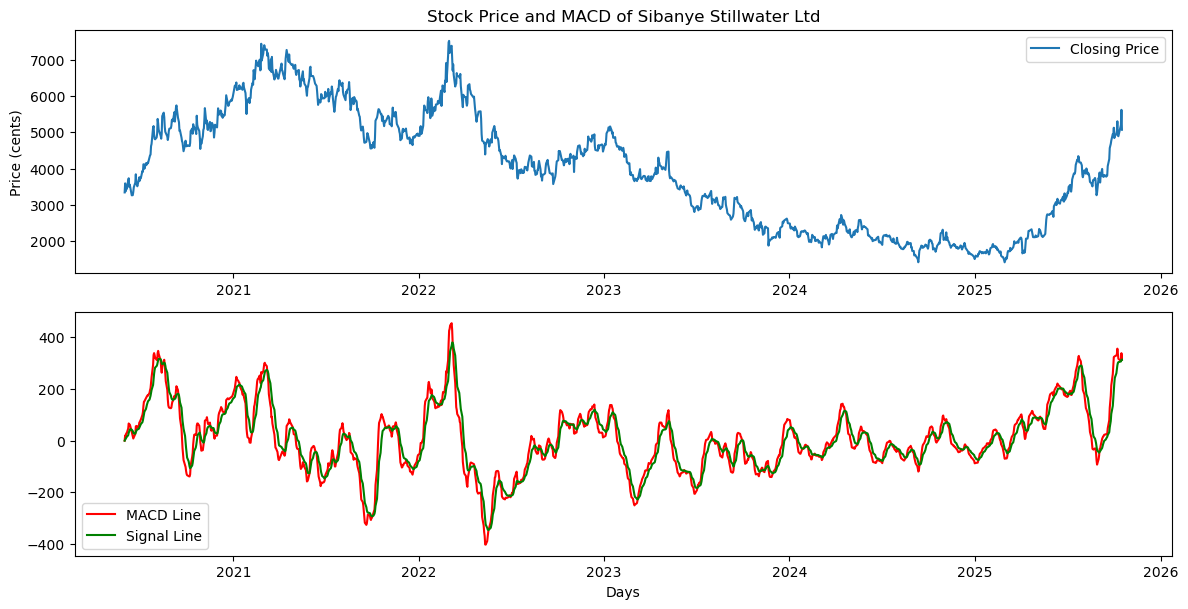

In [89]:
# Calculate MACD and Signal Line
macd_line, signal_line = calculate_macd(df["SSW.JO"])

# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Closing Prices
plt.subplot(2, 1, 1)
plt.plot(df["SSW.JO"], label='Closing Price')
plt.title('Stock Price and MACD of Sibanye Stillwater Ltd')
plt.legend()
plt.ylabel('Price (cents)')

# Plot RSI
plt.subplot(2, 1, 2)
plt.plot(macd_line, label='MACD Line', color='red')
plt.plot(signal_line, label='Signal Line', color='green')
plt.legend()
plt.tight_layout()
plt.xlabel('Days')
plt.show()